# 🧬 PCam Dataset: Tumor Detection via Binary Image Classification

For full dataset details, visit the official repository:  
🔗 [github.com/basveeling/pcam](https://github.com/basveeling/pcam)


## 📊 Dataset Overview

https://github.com/basveeling/pcam

The **PatchCamelyon (PCam)** benchmark is a challenging image classification dataset designed for breast cancer detection tasks.

- 📦 **Total images**: 327,680 color patches  
- 🖼️ **Image size**: 96 × 96 pixels
- 🧪 **Source**: Histopathologic scans of lymph node sections  
- 🏷️ **Labels**: Binary — A positive (1) label indicates that the center 32x32px region of a patch contains at least one pixel of tumor tissue. Tumor tissue in the outer region of the patch does not influence the label.

```
B. S. Veeling, J. Linmans, J. Winkens, T. Cohen, M. Welling. "Rotation Equivariant CNNs for Digital Pathology". arXiv:1806.03962
```

```
Ehteshami Bejnordi et al. Diagnostic Assessment of Deep Learning Algorithms for Detection of Lymph Node Metastases in Women With Breast Cancer. JAMA: The Journal of the American Medical Association, 318(22), 2199–2210. doi:jama.2017.14585
```

Under CC0 License


## 🧠 Solution to Implement

In this notebook, we implement a solution inspired by the following research paper:

> 📄 [**Cancer Image Classification Based on DenseNet Model**](https://arxiv.org/abs/2011.11186)  
> _by Zhong, Ziliang; Zheng, Muhang; Mai, Huafeng; Zhao, Jianan; Liu, Xinyi_

This study explores the application of DenseNet architectures to the PCam dataset for accurate cancer classification.

---

## Results

The submission on kaggle with the model trained on this notebook is 

```Public score: 0.9733```

### You can try it now ! With gradio 

On Hugging Face Spaces:

[![Hugging Face Spaces](https://img.shields.io/badge/🤗%20Hugging%20Face-Spaces-blue)](https://huggingface.co/spaces/eloise54/pcam_project)

### You can see the corresponding gitlab repo here 

[![GitLab Repo](https://img.shields.io/badge/GitLab-Repository-orange?logo=gitlab)](https://gitlab.com/robotics2ai/pcam_project)



# 1. Load the dataset
Load the training, test and validation datasets from PCAM.

We are going to use the kaggle version that is a cleaned version of the official PCAM dataset.

```
The original PCam dataset contains duplicate images due to its probabilistic sampling, however, the version presented on Kaggle does not contain duplicates. We have otherwise maintained the same data and splits as the PCam benchmark.
'''
In the kaggle version duplicates ar removed and there is no leakage between training and test datasets.

In [67]:
import typing as tp
import numpy as np
import torch
import torchvision
from torch import nn
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from torchvision.transforms import ToTensor 
from torchvision import datasets
from torch.utils.tensorboard import SummaryWriter

We need to use GPU if available

In [68]:
from torch.optim import Optimizer, lr_scheduler
from torch.optim.lr_scheduler import LRScheduler

if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print("Using device", device)

Using device cuda


Let's download the kaggle dataset.
For this you need your credentials.
If you did not set already your ```~/.kaggle/kaggle.json``` key:
 - Go to your kaggle account setting and create a new API token if needed.
 - Then feel in this part with your information ```creds = '{"username":"xxxxx","key":"xxxxx"}'```

In [69]:
!pip install kaggle
creds = '{"username":"xxxxx","key":"xxxxx"}'
from pathlib import Path

cred_path = Path('~/.kaggle/kaggle.json').expanduser()
if not cred_path.exists():
    cred_path.parent.mkdir(exist_ok=True)
    cred_path.write_text(creds)
    cred_path.chmod(0o600)


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [70]:
import os
import zipfile

root = "data/"
dataset_dir = "data/histopathologic-cancer-detection"
zip_file = "histopathologic-cancer-detection.zip"
train_path = os.path.join(dataset_dir, "train")

if not os.path.exists(root):
  os.mkdir(root)

if not os.path.exists('results'):
  os.mkdir('results')

if not os.path.exists(train_path):
    print("Downloading Histopathologic Cancer Detection dataset...")
    !kaggle competitions download -c histopathologic-cancer-detection -p {root} --force
else:
    print("Dataset zip already downloaded.")

if not os.path.exists(train_path):
    print("Unzipping dataset...")
    with zipfile.ZipFile(os.path.join(root, zip_file), 'r') as zip_ref:
        zip_ref.extractall(dataset_dir)
else:
    print("Dataset already unzipped.")

Dataset zip already downloaded.
Dataset already unzipped.


Know Let's create our pytorch dataset class.
I have used train_test_split from sklearn to have a stratified dataset (The kaggle PCAM dataset is unbalanced)

In [71]:
from sklearn.model_selection import train_test_split
from PIL import Image
import pandas as pd

class PcamDatasetKaggle(torchvision.datasets.VisionDataset):
    def __init__(self, root, split, transform, target_transform = None):
         super().__init__(root, transform=transform, target_transform=target_transform)
         self.root = root
         self.split = split
         self.transform = transform
         self.img_path = os.path.join(self.root, "train")

         self.full_labels = pd.read_csv(self.root+'/train_labels.csv')
         X_train, X_test, y_train, y_test = train_test_split(self.full_labels['id'],
                                                             self.full_labels['label'],
                                                             test_size = 0.2, 
                                                             train_size = 0.8,
                                                             random_state=42,
                                                             shuffle=True,
                                                             stratify=self.full_labels['label'])
        
         if (split == "train"):
             self.imgs = X_train + ".tif"
             self.labels = y_train
         elif (split == "val"):
             self.imgs = X_test + ".tif"
             self.labels = y_test
         else:
             self.img_path = os.path.join(self.root, self.split)
             self.imgs = pd.Series(list(sorted(os.listdir(self.img_path))))
             self.labels = pd.Series(torch.full((len(self.imgs),), -10))      
         assert len(self.labels) == len(self.imgs)
         print("Split", split, "Negative/Positive samples % " , 100.0*(self.labels.value_counts() / self.labels.shape[0]))

    def __getitem__(self, idx):
        assert idx < len(self.imgs)
        img = Image.open(os.path.join(self.img_path, self.imgs.iloc[idx]))
        if self.transform:
            img = self.transform(image = np.array(img))
        label = self.labels.iloc[idx]
        return img['image'].to(torch.float32), label
    def __len__(self) :
        return len(self.imgs)

def check_dataset_leakage(dataset1, dataset2):
    duplicates = set(dataset1.imgs) & set(dataset2.imgs)
    assert len(duplicates) == 0
    
def check_same_imgs(dataset1, dataset2):
    duplicates = set(dataset1.imgs) & set(dataset2.imgs)
    assert len(duplicates) == len(dataset1.imgs)
    assert len(duplicates) == len(dataset2.imgs)

Let's define some transforms for dataloading and data augmentation

In [72]:
import torchvision.transforms as transforms

torch.manual_seed(42)
torch.cuda.manual_seed_all(42)

# Preprocess images with transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)), #Match resnet original input size            
    transforms.ToTensor()
])

transform_data_augment = transforms.Compose([ 
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.GaussianBlur(kernel_size = (5,5),sigma=(0.2, 0.7)),
    transforms.RandomRotation(degrees=90),
    transforms.ColorJitter(
        brightness=0.4, 
        contrast=0.4, 
        saturation=0.1, 
        hue=0.03
    ),
    transforms.RandomResizedCrop(size = (224, 224), scale = (0.7, 1.0)),
    transforms.ToTensor()
])



Let's defined a more refined trasformation with (albumentations)[https://albumentations.ai/]

I have used the ```transform_data_augment``` from (link)[https://github.com/azkalot1/Histopathologic-Cancer-Detection/blob/master/utils.py] and added a normalization per channel layer to improve robustness and lessen overfitting

In [73]:
!pip install albumentations


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [74]:
import albumentations as A
transform_data_augment = A.Compose([A.Resize(224, 224), 
                    A.HorizontalFlip(), 
                    A.VerticalFlip(), 
                    A.RandomRotate90(), 
                    A.Transpose(), 
                    A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.50, rotate_limit=60, p=.75),
                    A.OpticalDistortion(),
                    A.GridDistortion(), 
                    A.RandomBrightnessContrast(p=0.3), 
                    A.RandomGamma(p=0.3), 
                    A.OneOf([A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=0.1, val_shift_limit=0.1, p=0.3), 
                            A.ChannelShuffle(p=0.3), A.CLAHE(p=0.3)]),
                    A.Normalize(normalization="image_per_channel", p=1.0),
                              A.ToTensorV2()])

transform = A.Compose([
                A.Resize(224, 224),
                A.Normalize(normalization="image_per_channel", p=1.0),
                A.ToTensorV2()
            ])

/home/light/python_envs/fastai/lib/python3.12/site-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


In [75]:
from copy import deepcopy

""" PCAM pytorch version but the dataset is not clean 
training_set_original = datasets.PCAM(root="data", split="train",download = True, transform = transform) 
training_set_augment = datasets.PCAM(root="data", split="train",download = True, transform = transform_data_augment)
val_set = datasets.PCAM(root="data", split="val", download=True, transform = transform)
test_set = datasets.PCAM(root="data", split="test", download=True, transform = transform)
"""

training_set_original = PcamDatasetKaggle(root=dataset_dir, split="train", transform = deepcopy(transform)) 
training_set_augment = PcamDatasetKaggle(root=dataset_dir, split="train", transform = deepcopy(transform_data_augment)) 

val_set = PcamDatasetKaggle(root=dataset_dir, split="val", transform = deepcopy(transform)) 
val_set_augment = PcamDatasetKaggle(root=dataset_dir, split="val", transform = deepcopy(transform_data_augment)) 

test_set = PcamDatasetKaggle(root=dataset_dir, split="test", transform = deepcopy(transform))
test_set_augment = PcamDatasetKaggle(root=dataset_dir, split="test", transform = deepcopy(transform_data_augment)) #For TTA

check_dataset_leakage(training_set_original, val_set)
check_dataset_leakage(training_set_original, test_set)
check_dataset_leakage(val_set, test_set)
check_same_imgs(training_set_original, training_set_augment)
check_same_imgs(val_set, val_set_augment)
check_same_imgs(test_set, test_set_augment)

Split train Negative/Positive samples %  label
0    59.496648
1    40.503352
Name: count, dtype: float64
Split train Negative/Positive samples %  label
0    59.496648
1    40.503352
Name: count, dtype: float64
Split val Negative/Positive samples %  label
0    59.497784
1    40.502216
Name: count, dtype: float64
Split val Negative/Positive samples %  label
0    59.497784
1    40.502216
Name: count, dtype: float64
Split test Negative/Positive samples %  -10    100.0
Name: count, dtype: float64
Split test Negative/Positive samples %  -10    100.0
Name: count, dtype: float64


# 2. Plot and visualize original and augmented the data
Each (3,96,96) image is associated with a binary label indicates the presence of a tumor.

Let's define a function to plot some images with their label.

Let's save the plots in an experiment directory for logging purposes


In [76]:
import matplotlib.pyplot as plt

def plot_training_set_sample(training_set, 
                             file_name = "results/pcam/data.png", 
                             rows = 5, 
                             cols = 5, 
                             mean_stdev = torch.Tensor([[0.0, 0.0, 0.0], [1.0, 1.0, 1.0]])):
    mean = mean_stdev[0].numpy()
    std  = mean_stdev[1].numpy()
    fig = plt.figure(figsize=(2*cols, 2*rows))
    for i in range(1, rows*cols + 1):
        random_idx = torch.randint(len(training_set), (1,)).item()
        fig.add_subplot(rows, cols, i)
        img = training_set[random_idx][0].permute(1,2,0).numpy() 
        img_unnormalized = img*std + mean
        img_unnormalized = np.clip(img_unnormalized, 0, 1)
        plt.imshow(img_unnormalized)
        plt.axis("off")
        plt.title(training_set[random_idx][1])
    plt.savefig(file_name)
    plt.show()
    

In [77]:
import os
from datetime import datetime
exp_dir = "results/pcam/"+datetime.now().strftime("%d_%m_%Y_%H_%M_%S")
os.makedirs(exp_dir)

Original Training Set


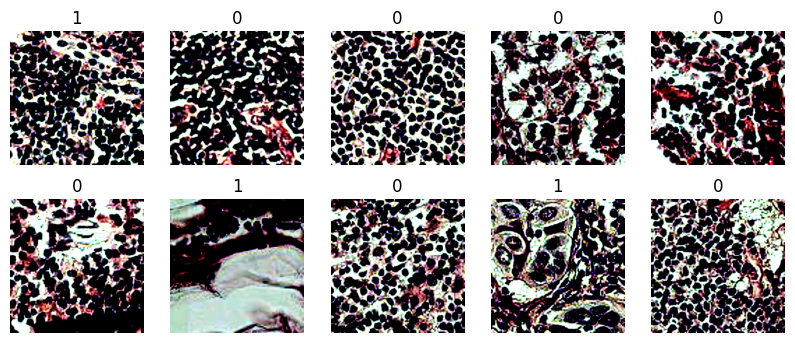

In [78]:
print("Original Training Set")
plot_training_set_sample(training_set_original, exp_dir + "/training_set_original.png",rows=2, cols=5)

Augmented Training Set


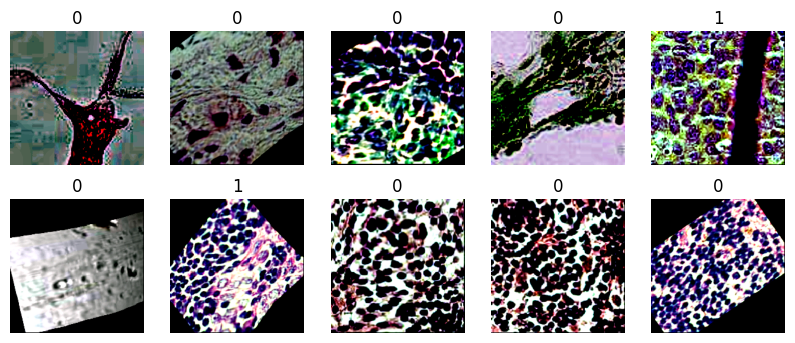

In [79]:
print("Augmented Training Set")
plot_training_set_sample(training_set_augment, exp_dir + "/training_set_augment.png",rows=2, cols=5)

# 3.Normalize and create augmented dataset

Let's create a function that computes mean, standard deviation and class balance for a pytorch DataLoader.

Normalize the datasets accordingly

In [81]:
# Create DataLoader
batch_size = 128
training_set_original = PcamDatasetKaggle(root=dataset_dir, split="train", transform = deepcopy(transform)) 
training_set_augment = PcamDatasetKaggle(root=dataset_dir, split="train", transform = deepcopy(transform_data_augment)) 
val_set = PcamDatasetKaggle(root=dataset_dir, split="val", transform = deepcopy(transform)) 
val_set_augment = PcamDatasetKaggle(root=dataset_dir, split="val", transform = deepcopy(transform_data_augment)) 
test_set = PcamDatasetKaggle(root=dataset_dir, split="test", transform = deepcopy(transform))


# Create Augmented Training Dataset
training_set = ConcatDataset([training_set_original, training_set_augment])

# Create Final DataLoaders
training_dataloader = DataLoader(training_set, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=6, persistent_workers = True)
val_dataloader = DataLoader(val_set, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=6, persistent_workers = True)
val_dataloader_augment = DataLoader(val_set_augment, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=6, persistent_workers = True)
test_dataloader = DataLoader(test_set, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=6, persistent_workers = True)


Split train Negative/Positive samples %  label
0    59.496648
1    40.503352
Name: count, dtype: float64
Split train Negative/Positive samples %  label
0    59.496648
1    40.503352
Name: count, dtype: float64
Split val Negative/Positive samples %  label
0    59.497784
1    40.502216
Name: count, dtype: float64
Split val Negative/Positive samples %  label
0    59.497784
1    40.502216
Name: count, dtype: float64
Split test Negative/Positive samples %  -10    100.0
Name: count, dtype: float64


Full Training Set Normalized


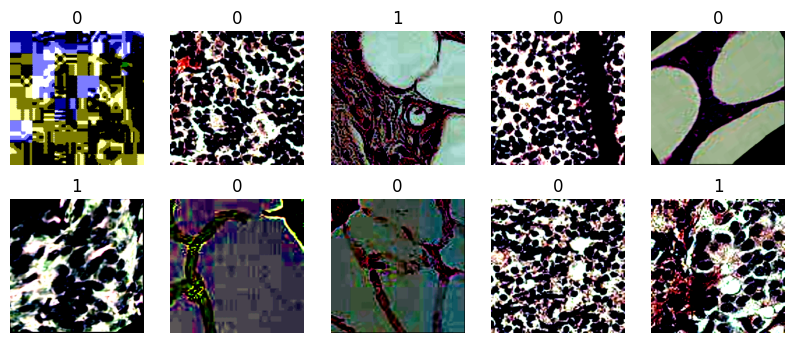

In [82]:
print("Full Training Set Normalized")
plot_training_set_sample(training_set, exp_dir + "/training_set_final.png", rows = 2, cols = 5)

# 3. Defining a training loop over one epoch and a metric
The dataset is not balance thus it is better to use roc_auc_score than accuracy

In [83]:
def compute_metrics(full_y: torch.Tensor, 
                    full_logits: torch.Tensor,  
                    full_pred: torch.Tensor,  
                    sk_learn_metrics_logits: tp.List[tp.Callable],
                    sk_learn_metrics_pred: tp.List[tp.Callable]) -> tp.Dict:
    full_y = full_y.detach().cpu().numpy()
    full_logits = torch.sigmoid(full_logits).detach().cpu().numpy()
    full_pred = full_pred.detach().cpu().numpy()
    
    results = {}
    for metric in sk_learn_metrics_logits:
        results[metric.__name__] = metric(full_y, full_logits)
    for metric in sk_learn_metrics_pred:
        results[metric.__name__] = metric(full_y, full_pred)
    return results

In [84]:
def run_one_epoch(model : nn.Module, 
                   training_dataloader: DataLoader,
                   optimizer: Optimizer,
                   loss_function: nn.Module,
                   scheduler : LRScheduler,
                   device: torch.cuda.device,
                   writer: SummaryWriter,
                   epoch: int,
                   sk_learn_metrics_logits: tp.List[tp.Callable],
                   sk_learn_metrics_pred: tp.List[tp.Callable],
                   threshold: float = 0.5):
    running_loss = 0.0
    num_batch = len(training_dataloader)
    full_y = torch.Tensor([]).to(device)
    full_logits = torch.Tensor([]).to(device)
    full_pred = torch.Tensor([]).to(device)
    
    model.train()
    scaler = torch.amp.GradScaler("cuda")
    for batch, (X, y) in enumerate(training_dataloader):
        optimizer.zero_grad()
        X = X.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True)
        with torch.amp.autocast("cuda"):
            logits = model(X).squeeze()
            loss = loss_function(logits, y.float())
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        with torch.no_grad():
            preds = (torch.sigmoid(logits) > threshold).float()
            full_y = torch.cat([full_y, y])
            full_logits = torch.cat([full_logits, logits])
            full_pred = torch.cat([full_pred, preds])
         
        running_loss += loss.item()
        avg_loss = running_loss / (batch + 1.)
        if batch % 250 == 0:
            writer.add_scalar('Training Loss(avg)', avg_loss, batch + epoch*num_batch)
            writer.add_scalar('Training Loss (raw)', loss.item(), batch + epoch*num_batch)
    scheduler.step()
    writer.flush()
    return compute_metrics(full_y, full_logits, full_pred, sk_learn_metrics_logits, sk_learn_metrics_pred)

In [85]:
def eval_model(model: nn.Module,
               dataloader: DataLoader, 
               sk_learn_metrics_logits: tp.List[tp.Callable],
               sk_learn_metrics_pred: tp.List[tp.Callable],
               device: torch.cuda.device,
               threshold: float = 0.5) -> tp.Dict:
    
    model.eval()
    full_y = torch.Tensor([]).to(device)
    full_logits = torch.Tensor([]).to(device)
    full_pred = torch.Tensor([]).to(device)
    
    with torch.no_grad():
        for X, y in dataloader:
            X = X.to(device)
            y = y.to(device)
            logits = model(X).squeeze()
            preds = (torch.sigmoid(logits) > threshold).float()

            full_y = torch.cat([full_y, y])
            full_logits = torch.cat([full_logits, logits])
            full_pred = torch.cat([full_pred, preds])
    return compute_metrics(full_y, full_logits, full_pred, sk_learn_metrics_logits, sk_learn_metrics_pred)

# 4. Setup tensorboard for monitoring

In [86]:
import threading 
import tensorboard
from tensorboard import program

def start_tensorboard(logdir):
    tb = program.TensorBoard()
    tb.configure(argv=[None, '--logdir', logdir])
    url = tb.launch()
    print(f"TensorBoard is running at {url}")

# Replace 'logs' with your actual log directory
logdir = exp_dir
tb_thread = threading.Thread(target=start_tensorboard, args=(logdir,), daemon=True)
tb_thread.start()


NOTE: Using experimental fast data loading logic. To disable, pass
    "--load_fast=false" and report issues on GitHub. More details:
    https://github.com/tensorflow/tensorboard/issues/4784



TensorBoard is running at http://localhost:6007/


In [87]:
from PIL import Image

def load_image(path):
    img = Image.open(path)
    # Convert to numpy array and add batch dimension (C, H, W)
    img_array = np.array(img)
    if len(img_array.shape) == 2:  # Grayscale image
        img_array = np.expand_dims(img_array, axis=0)  # (1, H, W)
    else:  # Color image
        img_array = img_array.transpose(2, 0, 1)  # (C, H, W)
    return img_array
    
writer = SummaryWriter(exp_dir + '/tensorboard')
writer.add_image('training_set_original', load_image(exp_dir + "/training_set_original.png"), 0)
writer.flush()
writer.add_image('training_set_augment',  load_image(exp_dir + "/training_set_augment.png"), 0)
writer.flush()
writer.add_image('training_set_final',  load_image(exp_dir + "/training_set_final.png"), 0)
writer.flush()

# 5. Find best learning rate

> 📄 [**Cancer Image Classification Based on DenseNet Model**](https://arxiv.org/abs/2011.11186)  
> _by Zhong, Ziliang; Zheng, Muhang; Mai, Huafeng; Zhao, Jianan; Liu, Xinyi_

Suggest to use a learning rate lr = 1e-4 for densenet201. 

You can also plot the loss with respect to the lr evaluated on a few batches.

It gives insight on which lr to take: between 1e-4 and 1e-3

I have added two fully layers connected layer and two dropout layers to prevent overfitting

/tmp/ipykernel_148812/3865851563.py:71: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


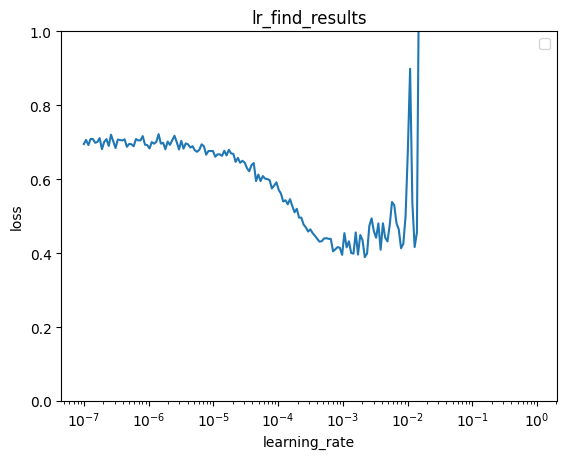

<Figure size 640x480 with 0 Axes>

In [ ]:
from torchvision.models import densenet201, DenseNet201_Weights
model = densenet201(weights=DenseNet201_Weights.DEFAULT)

for params in model.parameters():
    params.requires_grad = False

model.classifier = nn.Sequential(
    nn.Dropout(0.7),
    nn.Linear(model.classifier.in_features, 512, bias= True),
    nn.Dropout(0.5),
    nn.Linear(512, 1, bias= True))

for param in model.classifier.parameters():
    param.requires_grad = True

model = model.to(device)

def custom_lr_find(model : nn.Module, 
                   dataloader: DataLoader,
                   loss_function: nn.Module,
                   device: str,
                   start_lr = 1e-7,
                   end_lr = 1.0,
                   num_iteration = 200):
    rates = []
    lossses = []
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(),lr=start_lr)

    
    def lr_lambda(iteration):
        return (end_lr / start_lr) ** (iteration / num_iteration)
        
    scheduler = lr_scheduler.LambdaLR(optimizer, lr_lambda)
    initial_weights = model.state_dict()
    model.train()
    
    X_full = torch.Tensor([]).to(device)
    y_full = torch.Tensor([]).to(device)
    
    for h in range (0, 5):
        X, y = next(iter(dataloader))
        X = X.to(device)
        y = y.to(device)
        X_full = torch.cat([X_full, X])
        y_full = torch.cat([y_full, y])
    
    for i in range(0, num_iteration):
        optimizer.zero_grad()

        pred = model(X_full).squeeze()
        loss = loss_function(pred, y_full.float())
        lossses.append(loss.item())
        rates.append(scheduler.get_last_lr()[0])
        loss.backward()
        optimizer.step()
        scheduler.step()
        model.load_state_dict(initial_weights)
        if(scheduler.get_last_lr()[0] > end_lr):
            break
    return rates, lossses
        
def plot_lr_find(rates, losses, file_name):
    fig = plt.Figure()
    plt.plot(rates, losses)
    plt.xscale('log')
    plt.xlabel('learning_rate')
    plt.ylabel('loss')
    plt.ylim(0.0, 1.0)
    plt.title('lr_find_results')
    plt.legend()
    plt.savefig(file_name)
    plt.figure()
    
rates, losses = custom_lr_find(model, training_dataloader, torch.nn.BCEWithLogitsLoss(), device)
plot_lr_find(rates, losses, exp_dir + '/lr_find.jpg')
writer.add_image('lr_find', load_image(exp_dir + "/lr_find.jpg"), 0)
writer.flush()

# 6. Using already trained networks: Train the head only

First train the head and freeze all other layers

In [ ]:
from torchvision.models import densenet201, DenseNet201_Weights, densenet121, DenseNet121_Weights
model = densenet201(weights=DenseNet201_Weights.DEFAULT)

for params in model.parameters():
    params.requires_grad = False

#Replace the last layer (to output a 1d prediction)
model.classifier = nn.Sequential(
    nn.Dropout(0.7),
    nn.Linear(model.classifier.in_features, 512, bias= True),
    nn.Dropout(0.5),
    nn.Linear(512, 1, bias= True))

for param in model.classifier.parameters():
    param.requires_grad = True

model = model.to(device)

In [25]:
#optionnaly load from checkpoint
'''
model = torch.load('results/pcam/19_06_2025_11_08_15/model_'+str(5)+'.pt', weights_only = False)
for params in model.parameters():
    params.requires_grad = False
for param in model.classifier.parameters():
    param.requires_grad = True
model = model.to(device)
'''

"\nmodel = torch.load('results/pcam/19_06_2025_11_08_15/model_'+str(5)+'.pt', weights_only = False)\nfor params in model.parameters():\n    params.requires_grad = False\nfor param in model.classifier.parameters():\n    param.requires_grad = True\nmodel = model.to(device)\n"

In [26]:
lr = 1e-4

optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
loss_func = torch.nn.BCEWithLogitsLoss()
scheduler = lr_scheduler.StepLR(optimizer, step_size=1000, gamma=0.01)

In [27]:
from sklearn.metrics import classification_report, roc_auc_score, f1_score, precision_score, recall_score, accuracy_score, classification_report
import time
epoch_num = 2
sk_learn_metrics_logits = [roc_auc_score]
sk_learn_metrics_pred = [f1_score, accuracy_score]
for i in range(0, epoch_num):
    start_time = time.time()
    train_res = run_one_epoch(model,
                  training_dataloader,
                  optimizer,
                  loss_func,
                  scheduler,
                  device,
                  writer,
                  i,
                  sk_learn_metrics_logits,
                  sk_learn_metrics_pred)
    end_time = time.time()
    print("epoch n°: ", i, " training time : ", end_time-start_time, " sec")
    start_time = time.time()
    val_res = eval_model(model, val_dataloader, sk_learn_metrics_logits, sk_learn_metrics_pred, device)
    for key in train_res.keys():
        writer.add_scalars(key, {"Train " + key: train_res[key], "Val "+ key : val_res[key]}, i*len(training_dataloader))
    end_time = time.time()
    print("epoch n°: ", i, " evaluation time : ", end_time-start_time, " sec")
    torch.save(model, exp_dir+"/model_" + str(i) + ".pt")


epoch n°:  0  training time :  386.05869221687317  sec
epoch n°:  0  evaluation time :  53.800477027893066  sec
epoch n°:  1  training time :  400.62203335762024  sec
epoch n°:  1  evaluation time :  53.69089221954346  sec


# 7. Using already trained networks: Fine Tune a few layers
I did not use it in the end, this is optional

In [28]:
'''
for name, param in model.features.denseblock4.denselayer32.conv1.named_parameters():
    param.requires_grad = True
    
for name, param in model.features.denseblock4.denselayer32.conv2.named_parameters():
    param.requires_grad = True
'''

'\nfor name, param in model.features.denseblock4.denselayer32.conv1.named_parameters():\n    param.requires_grad = True\n    \nfor name, param in model.features.denseblock4.denselayer32.conv2.named_parameters():\n    param.requires_grad = True\n'

In [29]:
# Unfreeze last two blocks (features.6 and features.7)
'''
lr = 1e-4
#optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
#loss_func = torch.nn.BCEWithLogitsLoss(pos_weight=pos_weight)
loss_func = torch.nn.BCEWithLogitsLoss()
# Use lower LR for fine-tuning
optimizer = torch.optim.Adam([
    {"params": model.classifier.parameters(), "lr": 1e-4},
     {"params": model.features.denseblock4.denselayer32.conv1.parameters(), "lr": 1e-5},
     {"params": model.features.denseblock4.denselayer32.conv2.parameters(), "lr": 1e-5},
 ])
'''

'\nlr = 1e-4\n#optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)\n#loss_func = torch.nn.BCEWithLogitsLoss(pos_weight=pos_weight)\nloss_func = torch.nn.BCEWithLogitsLoss()\n# Use lower LR for fine-tuning\noptimizer = torch.optim.Adam([\n    {"params": model.classifier.parameters(), "lr": 1e-4},\n     {"params": model.features.denseblock4.denselayer32.conv1.parameters(), "lr": 1e-5},\n     {"params": model.features.denseblock4.denselayer32.conv2.parameters(), "lr": 1e-5},\n ])\n'

In [30]:
'''
from sklearn.metrics import classification_report, roc_auc_score, f1_score, precision_score, recall_score, accuracy_score, classification_report
import time
sk_learn_metrics_logits = [roc_auc_score]
sk_learn_metrics_pred = [f1_score, accuracy_score]
epoch_num = 2
finetune_epoch_num = 6
for i in range(epoch_num, epoch_num + finetune_epoch_num):
    start_time = time.time()
    train_res = run_one_epoch(model,
                  training_dataloader,
                  optimizer,
                  loss_func,
                  scheduler,
                  device,
                  writer,
                  i,
                  sk_learn_metrics_logits,
                  sk_learn_metrics_pred)
    end_time = time.time()
    print("epoch n°: ", i, " training time : ", end_time-start_time, " sec")
    start_time = time.time()
    val_res = eval_model(model, val_dataloader, sk_learn_metrics_logits, sk_learn_metrics_pred, device)
    for key in train_res.keys():
        writer.add_scalars(key, {"Train " + key: train_res[key], "Val "+ key : val_res[key]}, i*len(training_dataloader))
    end_time = time.time()
    print("epoch n°: ", i, " evaluation time : ", end_time-start_time, " sec")
    torch.save(model, exp_dir+"/model_" + str(i) + ".pt")

'''

'\nfrom sklearn.metrics import classification_report, roc_auc_score, f1_score, precision_score, recall_score, accuracy_score, classification_report\nimport time\nsk_learn_metrics_logits = [roc_auc_score]\nsk_learn_metrics_pred = [f1_score, accuracy_score]\nepoch_num = 2\nfinetune_epoch_num = 6\nfor i in range(epoch_num, epoch_num + finetune_epoch_num):\n    start_time = time.time()\n    train_res = run_one_epoch(model,\n                  training_dataloader,\n                  optimizer,\n                  loss_func,\n                  scheduler,\n                  device,\n                  writer,\n                  i,\n                  sk_learn_metrics_logits,\n                  sk_learn_metrics_pred)\n    end_time = time.time()\n    print("epoch n°: ", i, " training time : ", end_time-start_time, " sec")\n    start_time = time.time()\n    val_res = eval_model(model, val_dataloader, sk_learn_metrics_logits, sk_learn_metrics_pred, device)\n    for key in train_res.keys():\n        w

# 8. Fine tune the entire model

In [31]:
for params in model.parameters():
    params.requires_grad = True

lr = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
loss_func = torch.nn.BCEWithLogitsLoss()
scheduler = lr_scheduler.StepLR(optimizer, step_size=1000, gamma=0.01)

In [ ]:
from sklearn.metrics import classification_report, roc_auc_score, f1_score, precision_score, recall_score, accuracy_score, classification_report
import time
sk_learn_metrics_logits = [roc_auc_score]
sk_learn_metrics_pred = [f1_score, accuracy_score]
epoch_num = 2
finetune_epoch_num = 5
    
for i in range(epoch_num, epoch_num + finetune_epoch_num):
    start_time = time.time()
    train_res = run_one_epoch(model,
                  training_dataloader,
                  optimizer,
                  loss_func,
                  scheduler,
                  device,
                  writer,
                  i,
                  sk_learn_metrics_logits,
                  sk_learn_metrics_pred)
    end_time = time.time()
    print("epoch n°: ", i, " training time : ", end_time-start_time, " sec")
    start_time = time.time()
    val_res = eval_model(model, val_dataloader, sk_learn_metrics_logits, sk_learn_metrics_pred, device)
    for key in train_res.keys():
        writer.add_scalars(key, {"Train " + key: train_res[key], "Val "+ key : val_res[key]}, i*len(training_dataloader))
    end_time = time.time()
    print("epoch n°: ", i, " evaluation time : ", end_time-start_time, " sec")
    torch.save(model, exp_dir+"/model_" + str(i) + ".pt")

epoch n°:  4  training time :  700.690135717392  sec
epoch n°:  4  evaluation time :  54.007465839385986  sec
epoch n°:  5  training time :  702.625905752182  sec
epoch n°:  5  evaluation time :  54.13493227958679  sec


# 9. Compute test set prediction and submit to kaggle

We will use TTA (Test Time with Augmentation).
We can also optionally use several models to make a prediction and average the results

In [89]:
def run_inference(model: nn.Module,
                     dataloader: DataLoader, 
                     device: torch.cuda.device):
    
    model.eval()
    full_y = torch.Tensor([]).to(device)
    full_logits = torch.Tensor([]).to(device)
    
    with torch.no_grad():
        for X, y in dataloader:
            X = X.to(device)
            y = y.to(device)
            logits = model(X).squeeze()

            full_y = torch.cat([full_y, y])
            full_logits = torch.cat([full_logits, logits])

    return full_y, full_logits

In [ ]:
for i in range(0, epoch_num + finetune_epoch_num):
    models_paths = [exp_dir+"/model_" + str(i) + ".pt"]
    pcam_model = torch.load(models_paths[0], weights_only = False)
    pcam_model = pcam_model.to(device)

    # First create tta_num augmented dataloaders
    tta_num = 1
    logits = []
    for j in range(0, tta_num):
        test_set_augment = PcamDatasetKaggle(root=dataset_dir, split="test", transform = deepcopy(transform_data_augment)) #For TTA
        test_dataloader_augment = DataLoader(test_set_augment, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=6, persistent_workers = True)
        for modelp in models_paths:
            pcam_model = torch.load(modelp, weights_only = False)
            pcam_model = pcam_model.to(device)
            test_y, test_logits = run_inference(pcam_model, test_dataloader, device)
            logits.append(test_logits)
            test_y_augm, test_logits_aum = run_inference(pcam_model, test_dataloader_augment, device)
            logits.append(test_logits_aum)
        
    # Average logits
    logits_stacked = torch.stack(logits)
    mean_logits = torch.mean(logits_stacked, dim = 0, keepdims=True)

    #Create submission file with final predictions
    image_ids = [img.replace('.tif', '') for img in test_set.imgs.tolist()]
    test_preds = torch.sigmoid(mean_logits)

    submission_df = pd.DataFrame({
        'id': image_ids,
        'label': test_preds.squeeze().detach().cpu().numpy()
    })

    submission_df.to_csv(exp_dir+'/submission_'+str(i)+'.csv', index=False)

Split test Negative/Positive samples %  -10    100.0
Name: count, dtype: float64


In [ ]:
sub_path = exp_dir + '/submission_6.csv'
model_path = models_paths[0]
!kaggle competitions submit -c histopathologic-cancer-detection -f {sub_path} -m {model_path}

100%|██████████████████████████████████████| 2.88M/2.88M [00:02<00:00, 1.23MB/s]
Successfully submitted to Histopathologic Cancer Detection

# 11. Find best threshold for prediction on validation set

In [ ]:
i = 6
models_paths = [exp_dir+"/model_" + str(i) + ".pt"]
pcam_model = torch.load(models_paths[0], weights_only = False)
pcam_model = pcam_model.to(device)
test_y, test_logits = run_inference(pcam_model, val_dataloader, device)
test_y_augment, test_logits_augment = run_inference(pcam_model, val_dataloader_augment, device)
full_y = torch.cat([test_y, test_y_augment])
full_logits = torch.cat([test_logits, test_logits_augment])

In [99]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(full_y.detach().cpu().numpy(), torch.sigmoid(full_logits).detach().cpu().numpy())
roc_auc = auc(fpr, tpr)

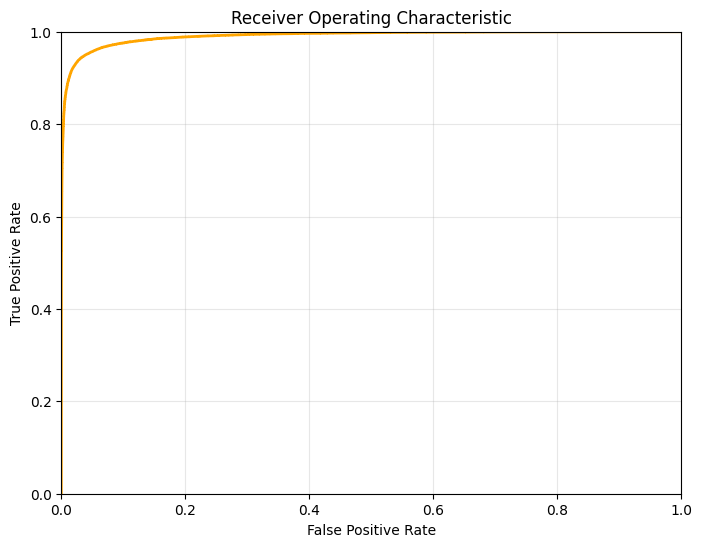

In [100]:
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='orange', lw=2, label=f'ROC curve (AUC = {roc_auc})')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.grid(alpha=0.3)
plt.show()


In [101]:
# Find best threshold index (maximize TPR-FPR).
j_scores = tpr - fpr
best_idx = np.argmax(j_scores)
best_threshold = thresholds[best_idx]


In [102]:
best_threshold

np.float32(0.4458489)